In [2]:
import numpy as np
import pandas as pd
import torch
import torchaudio
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms, utils
import os
from scipy import signal
import librosa

dataset_folder = '../HF_Lung_V1'
train_data_path = os.path.join(dataset_folder, 'train')
test_data_path = os.path.join(dataset_folder, 'test')

SAMPLE_RATE = 4000
ALL_LABELS = ['I', 'D', 'E', 'Rhonchi', 'Wheeze', 'Stridor']


In [3]:
import torchaudio.functional as F
import torchaudio.transforms as T


Creating A Torch DataSet for training


In [4]:
class LungDataSet(Dataset):
    def __init__(self, file_list, transform, targets_transform):
        self.file_list = file_list
        self.target_transform = targets_transform
        self.target_sample_rate = SAMPLE_RATE
        self.transform = transform.to(self.device)

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, index):
        audio_sample_path = self._get_audio_sample_path(index)
        labels = self.__get_audio_sample_labels(index)

        # Read Audio from path
        wav, sample_rate = librosa.load(audio_sample_path, sr=None, mono=False)
        cutoff_freq = 15

        # Apply high pass filter cutoff = 80Hz, filter order = 10
        b, a = signal.butter(N=10, Wn=cutoff_freq,
                             btype='high', fs=sample_rate)
        wav_filtered = signal.filtfilt(b, a, wav)

        # Convert the np array to torch tensor and transfer to device
        torch_signal = torch.tensor(wav_filtered.copy()).reshape(1, -1)

        # Resample the signal to 4kHz
        torch_signal = self._resample_if_necessary(torch_signal, sample_rate)

        # Apply transformations
        if self.transform:
            torch_signal = self.transform(torch_signal)
        if self.target_transform:
            labels = self.target_transform(torch_signal, labels)

        return torch_signal, labels

    def _get_audio_sample_path(self, index):
        path = os.path.join(self.file_list[index] + ".wav")
        return path

    def __get_audio_sample_labels(self, index):
        path = os.path.join(self.file_list[index] + "_label.txt")
        labels = pd.read_csv(path, sep=' ', header=None,
                             names=["class", "start", "end"])
        labels['start'] = pd.to_timedelta(labels['start']).dt.total_seconds()
        labels['end'] = pd.to_timedelta(labels['end']).dt.total_seconds()
        return labels

    def _resample_if_necessary(self, signal, sr):
        if sr != self.target_sample_rate:
            resampler = torchaudio.transforms.Resample(
                sr, self.target_sample_rate)
            signal = resampler(signal)

        return signal


In [5]:
list_files = []
data_folder = train_data_path
for file in os.listdir(data_folder):
    if file.endswith(".wav"):
        list_files.append(os.path.join(data_folder, os.path.splitext(file)[0]))
list_files[0]


'../HF_Lung_V1\\train\\steth_20180814_09_37_11'

In [6]:
file_list = list_files[:2]
path = os.path.join(file_list[0] + "_label.txt")
labels = pd.read_csv(path, sep=' ', header=None,
                     names=["class", "start", "end"])
labels['start'] = pd.to_timedelta(labels['start']).dt.total_seconds()
labels['end'] = pd.to_timedelta(labels['end']).dt.total_seconds()
max(labels['end'])


13.829

In [7]:
window_function = torch.hamming_window
window_length = 256
hop_length = 64
spectrogram = torchaudio.transforms.Spectrogram(
    # sample_rate=SAMPLE_RATE,
    n_fft=256,
    win_length=window_length,
    hop_length=hop_length,
    window_fn=window_function
)


In [8]:
wav, sample_rate = torchaudio.load(os.path.join(file_list[0] + ".wav"))
cutoff_freq = 80

# start = np.floor(min(labels['start']) * sample_rate).astype(int)
# end = np.floor(max(labels['end']) * sample_rate).astype(int)
# wav_trim = wav[start:end]

# librosa.get_duration(y=wav_trim)

b, a = signal.butter(N=10, Wn=cutoff_freq, btype='high', fs=sample_rate)
wav_filtered = signal.filtfilt(b, a, wav)

# signal1, sr = torchaudio.load(os.path.join(file_list[2] + ".wav"))
torch_signal = torch.tensor(wav_filtered.copy()).reshape(1, -1)

resampler = torchaudio.transforms.Resample(sample_rate, SAMPLE_RATE)
torch_signal = resampler(torch_signal)

torch_signal = spectrogram(torch_signal)

torch_signal.shape[-1]
wav.shape
# signal1.shape


torch.Size([1, 60000])

In [9]:
import matplotlib.pyplot as plt


In [10]:
def plot_waveform(waveform, sample_rate, title="Waveform", xlim=None):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate

    figure, axes = plt.subplots(num_channels, 1, figsize=(9, 5))
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].plot(time_axis, waveform[c], linewidth=1)
        axes[c].grid(True)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
        if xlim:
            axes[c].set_xlim(xlim)
    figure.suptitle(title)
    plt.xlabel("Time")
    plt.show(block=False)


In [11]:
def plot_specgram(waveform, sample_rate, title="Spectrogram", xlim=None):
    waveform = waveform.numpy()

    num_channels, _ = waveform.shape

    figure, axes = plt.subplots(num_channels, 1, figsize=(9, 5))
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].specgram(waveform[c], Fs=sample_rate)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
        if xlim:
            axes[c].set_xlim(xlim)
    figure.suptitle(title)
    plt.ylabel("Frequency dimensions")
    plt.xlabel("Time")
    plt.show(block=False)


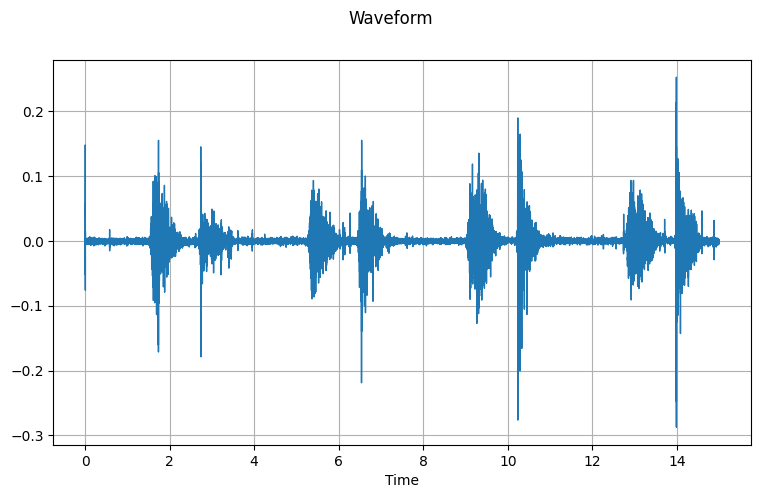

In [12]:
plot_waveform(wav, sample_rate)


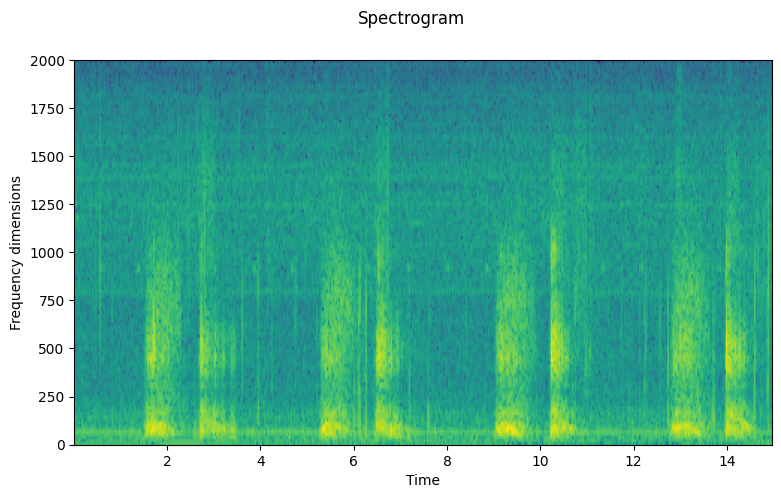

In [13]:
plot_specgram(wav, sample_rate)


In [14]:
path = os.path.join(file_list[0] + "_label.txt")
labels = pd.read_csv(path, sep=' ', header=None,
                     names=["class", "start", "end"])
labels['start'] = pd.to_timedelta(labels['start']).dt.total_seconds()
labels['end'] = pd.to_timedelta(labels['end']).dt.total_seconds()
# encoded_labels =


In [15]:
wav, sample_rate = librosa.load(os.path.join(
    file_list[0] + ".wav"), sr=None, mono=False)
start = np.floor(min(labels['start']) * sample_rate).astype(int)
end = np.floor(max(labels['end']) * sample_rate).astype(int)
wav_trim = wav[start:end]
# librosa.get_duration(y=wav_trim, sr=sample_rate)
min(labels['start'])


1.5

In [16]:
# labels.info()
torch_signal.shape


torch.Size([1, 129, 938])

In [17]:
windows = torch_signal.shape[-1]
start = min(labels['start'])*1000
end = max(labels['end'])*1000
sample_size = end - start
window_size = np.floor(sample_size/windows)
# window_size
class_label = ['']*windows
max_frames = np.zeros(windows)
for i in range(windows):
    win_start = i*window_size + start
    win_end = win_start + window_size
    print("win: ", win_start, win_end)
    for index, row in labels.iterrows():
        # print(pd.to_timedelta(row['start']).total_seconds())
        row_start = row['start']*1000
        row_end = row['end']*1000
        print("row label: ", row['class'], row_start, row_end)
        if (row_start >= win_start) and (row_start <= win_end):
            num_frames_in_win = min(win_end, row_end) - \
                max(win_start, row_start)
            print("num frames ", num_frames_in_win)
            print("maxframes ", max_frames[i])
            if num_frames_in_win > max_frames[i]:
                class_label[i] = row['class']
                max_frames[i] = num_frames_in_win
            print("class label ", class_label[i])
class_label


win:  1500.0 1513.0
row label:  I 1500.0 2457.0
num frames  13.0
maxframes  0.0
class label  I
row label:  D 1500.0 2457.0
num frames  13.0
maxframes  13.0
class label  I
row label:  E 2608.0 3637.0
row label:  D 2608.0 3637.0
row label:  I 5227.0 6350.0
row label:  D 5227.0 6350.0
row label:  E 6431.0 7411.0
row label:  D 6431.0 7411.0
row label:  I 9038.0 10019.0
row label:  E 10205.0 11186.0
row label:  D 10205.0 11186.0
row label:  I 12754.0 13829.0
row label:  Rhonchi 12754.0 13485.0
win:  1513.0 1526.0
row label:  I 1500.0 2457.0
row label:  D 1500.0 2457.0
row label:  E 2608.0 3637.0
row label:  D 2608.0 3637.0
row label:  I 5227.0 6350.0
row label:  D 5227.0 6350.0
row label:  E 6431.0 7411.0
row label:  D 6431.0 7411.0
row label:  I 9038.0 10019.0
row label:  E 10205.0 11186.0
row label:  D 10205.0 11186.0
row label:  I 12754.0 13829.0
row label:  Rhonchi 12754.0 13485.0
win:  1526.0 1539.0
row label:  I 1500.0 2457.0
row label:  D 1500.0 2457.0
row label:  E 2608.0 3637.0
row

['I',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 'E',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 ''

In [18]:
# torch_signal.shape


In [19]:
all_class_labels = ['I', 'D', 'E', 'Rhonchi', 'Wheeze', 'Stridor']
windows = torch_signal.shape[-1]
labels_array = np.zeros([windows, len(all_class_labels)])
start = 0
end = 15*sample_rate
sample_size = end - start
window_size = np.ceil(sample_size/windows)
window_size


64.0

In [20]:
all_class_labels = ['I', 'D', 'E', 'Rhonchi', 'Wheeze', 'Stridor']
windows = torch_signal.shape[-1]
labels_array = np.zeros([windows, len(all_class_labels)])
start = 0
end = 15*sample_rate
sample_size = end - start
window_size = np.ceil(sample_size/windows)
# window_size
# class_label = ['']*windows
# max_frames = np.zeros(windows)
for i in range(windows):
    win_start = i*window_size
    win_end = win_start + window_size
    
    print("i: ", i)
    print("win: ", win_start, win_end)
    for index, row in labels.iterrows():
        row_start = row['start']*1000
        row_end = row['end']*1000
        print("row label: ", row['class'], row_start, row_end)
        if (row_start <= win_start) and (row_end >= win_end):
            labels_array[i][all_class_labels.index(row['class'])] = 1
list(labels_array)


i:  0
win:  0.0 64.0
row label:  I 1500.0 2457.0
row label:  D 1500.0 2457.0
row label:  E 2608.0 3637.0
row label:  D 2608.0 3637.0
row label:  I 5227.0 6350.0
row label:  D 5227.0 6350.0
row label:  E 6431.0 7411.0
row label:  D 6431.0 7411.0
row label:  I 9038.0 10019.0
row label:  E 10205.0 11186.0
row label:  D 10205.0 11186.0
row label:  I 12754.0 13829.0
row label:  Rhonchi 12754.0 13485.0
i:  1
win:  64.0 128.0
row label:  I 1500.0 2457.0
row label:  D 1500.0 2457.0
row label:  E 2608.0 3637.0
row label:  D 2608.0 3637.0
row label:  I 5227.0 6350.0
row label:  D 5227.0 6350.0
row label:  E 6431.0 7411.0
row label:  D 6431.0 7411.0
row label:  I 9038.0 10019.0
row label:  E 10205.0 11186.0
row label:  D 10205.0 11186.0
row label:  I 12754.0 13829.0
row label:  Rhonchi 12754.0 13485.0
i:  2
win:  128.0 192.0
row label:  I 1500.0 2457.0
row label:  D 1500.0 2457.0
row label:  E 2608.0 3637.0
row label:  D 2608.0 3637.0
row label:  I 5227.0 6350.0
row label:  D 5227.0 6350.0
row la

[array([0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0.]),
 array([1., 1., 0., 0., 0., 0.]),
 array([1., 1., 0., 0., 0., 0.]),
 array([1., 1., 0., 0., 0., 0.]),
 array([1., 1., 0., 0., 0., 0.]),
 array([1., 1., 0., 0., 0., 0.]),
 array([1., 1.

In [21]:
windows = torch_signal.shape[-1]
labels_array = np.zeros([windows, len(ALL_LABELS)])
start = 0
end = 15*sample_rate
window_size = np.ceil((end - start)/windows)
for i in range(windows):
    win_start = i*window_size + start
    win_end = win_start + window_size
    for index, row in labels.iterrows():
        row_start = row['start']*1000
        row_end = row['end']*1000
        if (row_start <= win_start) and (row_end >= win_end):
            labels_array[i][ALL_LABELS.index(row['class'])] = 1
end

60000

In [22]:
def label_encoder(torch_signal, labels):
    windows = torch_signal.shape[-1]
    labels_array = np.zeros([windows, len(ALL_LABELS)])
    start = 0
    end = 15*sample_rate
    window_size = np.ceil((end - start)/windows)
    for i in range(windows):
        win_start = i*window_size + start
        win_end = win_start + window_size
        for index, row in labels.iterrows():
            row_start = row['start']*sample_rate
            row_end = row['end']*sample_rate
            if (row_start <= win_start) and (row_end >= win_end):
                labels_array[i][ALL_LABELS.index(row['class'])] = 1
    return labels_array


In [23]:
all_labels = []
for file in file_list:
    path = os.path.join(file + "_label.txt")
    labels = pd.read_csv(path, sep=' ', header=None,
                         names=["class", "start", "end"])
    labels['start'] = pd.to_timedelta(labels['start']).dt.total_seconds()
    labels['end'] = pd.to_timedelta(labels['end']).dt.total_seconds()
    all_labels.append(labels)

all_labels_df = pd.concat(all_labels)
all_labels_df['class'].unique()


array(['I', 'D', 'E', 'Rhonchi'], dtype=object)

In [24]:
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt


In [25]:
class LungDataSet(Dataset):
    def __init__(self, file_list, transform, targets_transform):
        self.file_list = file_list
        self.target_transform = targets_transform
        self.target_sample_rate = SAMPLE_RATE
        self.transform = transform

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, index):
        audio_sample_path = self._get_audio_sample_path(index)
        labels = self.__get_audio_sample_labels(index)

        # Read Audio from path
        wav, sample_rate = librosa.load(audio_sample_path, sr=None, mono=False)
        cutoff_freq = 80

        # Apply high pass filter cutoff = 80Hz, filter order = 10
        b, a = signal.butter(N=10, Wn=cutoff_freq,
                             btype='high', fs=sample_rate)
        wav_filtered = signal.filtfilt(b, a, wav)

        # Convert the np array to torch tensor and transfer to device
        torch_signal = torch.tensor(wav_filtered.copy()).reshape(1, -1)

        # Resample the signal to 4kHz
        torch_signal = self._resample_if_necessary(torch_signal, sample_rate)

        # Apply transformations
        if self.transform:
            torch_signal = self.transform(torch_signal)
        if self.target_transform:
            labels = self.target_transform(torch_signal, labels)

        return torch_signal, labels

    def _get_audio_sample_path(self, index):
        path = os.path.join(self.file_list[index] + ".wav")
        return path

    def __get_audio_sample_labels(self, index):
        path = os.path.join(self.file_list[index] + "_label.txt")
        labels = pd.read_csv(path, sep=' ', header=None,
                             names=["class", "start", "end"])
        labels['start'] = pd.to_timedelta(labels['start']).dt.total_seconds()
        labels['end'] = pd.to_timedelta(labels['end']).dt.total_seconds()
        return labels

    def _resample_if_necessary(self, signal, sr):
        if sr != self.target_sample_rate:
            resampler = torchaudio.transforms.Resample(
                sr, self.target_sample_rate)
            signal = resampler(signal)

        return signal


In [70]:
def create_dataloader(train_data, batch_size):
    train_dataloader = DataLoader(train_data, batch_size=batch_size)
    return train_dataloader

def collate_fn(batch):
    # A data tuple has the form:
    # waveform, sample_rate, label, speaker_id, utterance_number
    tensors, targets = [], []
    # Gather in lists, and encode labels as indices
    for waveform, label in batch:
        tensors += [waveform]
        targets += [torch.tensor(label, dtype=torch.long)]
    # Group the list of tensors into a batched tensor
    targets = torch.stack(targets)
    return tensors, targets

def train_single_epoch(model, train_loader, optimizer, device):
    losses = []
    for batch_idx, (data, label) in enumerate(train_loader):
        print("data ", data.shape)
        data = data.to(device)
        label = label.to(device)

        output = model(data)
        loss = F.cross_entropy(output.squeeze(), label.long())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    return sum(losses)/len(losses)


def train_network(net, criterion, optimizer, train_loader,
                  test_loader, num_epochs=1, verbose=True,
                  training_plot=True, device='cpu'):

    training_loss = np.zeros(num_epochs)
    validation_loss = np.zeros(num_epochs)

    for epoch in range(num_epochs):  # Loop over the dataset multiple times
        running_loss = 0.0

        net.train()

        training_loss[epoch] = train_single_epoch(
            net, train_loader, optimizer, device)
        validation_losses = validate(net, test_loader, optimizer, device)

        train_total, train_acc = test(train_loader, device)
        val_total, val_acc = test(test_loader, device)
        if verbose:
            print(
                f'\nAccuracy on the {train_total} training samples: {train_acc:0.2f}')
            print(
                f'Accuracy on the {val_total} validation samples: {val_acc:0.2f}\n')
        if training_plot:
            train_line = plt.plot(training_loss, label="Train Loss")
            validation_line = plt.plot(
                validation_loss, label="Validation Loss")
            plt.legend()
            # plt.savefig(f"Figures/EMG_loss_{r}.png")
            plt.show()
            plt.clf()
        return train_acc, val_acc


def validate(model, validation_loader, device):
    # Evaluate the model
    # model.eval - disable gradient tracking, batch normalization, dropout
    model.eval()
    # Store losses of this epoch in a list (element = loss on batch)
    losses = []

    for batch_idx, (data, label) in enumerate(validation_loader):
        # Send data, labels to GPU if GPU is available
        data = data.to(device)
        label = label.to(device)
        # Passing data to model calls the forward method.
        output = model(data)
        # Output: (batch_size, n_class)
        # Use negative log likelihood loss for validation
        loss = F.cross_entropy(output, label.long())
        # Store the loss of this batch
        losses.append(loss.item())

    # Return the average validation loss on this epoch
    return sum(losses)/len(losses)


def test(net, data_loader, device):
    correct = 0
    total = 0
    for data in data_loader:
        inputs, labels = data
        inputs = inputs.to(device).float()
        labels = labels.to(device).long()

        outputs = net(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    acc = 100 * correct / total
    return total, acc


In [75]:
def training_loop(num_epochs, model, optimizer, scheduler, loss_fn, train_loader, test_loader, device):
    model.train()
    training_losses   = []
    training_accuracy = []
    testing_losses    = []
    testing_accuracy  = []
    for e in range(num_epochs):
        train_batch_loss        = []
        testing_batch_loss      = []
        train_batch_accuracy    = []
        testing_batch_accuracy  = []
        # update weights using training data
        for data, labels in train_loader:
            optimizer.zero_grad()
            data = data.to(device)
            labels = labels.to(device)

            # data is (batch_size x 40 x number of frames)
            out = model(data)
            # out returns a class prediction for every sample of our sequence for each batch
            # [TIME, batch, num_output_classes]
            # we only want to perform backpropagation for what we think it is at the end of the sequence
            # out = out[-1,:,:].squeeze()
            loss = loss_fn(out, labels)
            loss.backward()
            optimizer.step()
            # keep track of the loss

            pred = np.argmax(out.detach().cpu().numpy(), axis=1)
            accuracy = sum(pred == labels.detach().cpu().numpy())/train_loader.batch_size
            train_batch_loss.append(loss.item())
            train_batch_accuracy.append(accuracy)

        with torch.no_grad():
            # see how classifying ahead looks on the test data
            # just do the same thing without loss.backward()
            for data, labels in test_loader:
                data = data.to(device)
                labels = labels.to(device)
                out = model(data)
                out = out[-1,:,:].squeeze()
                loss = loss_fn(out, labels)
                pred = np.argmax(out.detach().cpu().numpy(), axis=1)
                accuracy = sum(pred == labels.detach().cpu().numpy())/train_loader.batch_size
                testing_batch_loss.append(loss.item())
                testing_batch_accuracy.append(accuracy)
            # usually you run step on the validation loss (when using reduceLRonPlateau),
            # but this example does not use a validation set, and we are running StepLR as our scheduler
            scheduler.step()
        
        training_losses.append(sum(train_batch_loss)/len(train_batch_loss))
        testing_losses.append(sum(testing_batch_loss)/len(testing_batch_loss))
        training_accuracy.append(sum(train_batch_accuracy)/len(train_batch_accuracy))
        testing_accuracy.append(sum(testing_batch_accuracy)/len(testing_batch_accuracy))
            
        # print out epoch metrics
        print('-'*15)

        print("Epoch: {}:".format(e+1))
        print("\t train loss: {:.2f}, test loss: {:.2f}".format(training_losses[-1], testing_losses[-1]))
        print("\t train accuracy: {:.2f}, test accuracy: {:.2f}".format(training_accuracy[-1], testing_accuracy[-1]))

    return training_losses, testing_losses, training_accuracy, testing_accuracy

In [78]:
import torch.nn as nn
import torch.optim as optim
import random


def set_random_seeds(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    random.seed(seed)
    print(f'Random seed {seed} has been set.')


class Net(nn.Module):
    def __init__(self, num_recurrent_layers, num_input_features, hidden_layer_nodes, output_feature_nums, dropout_prob=0, bidirectional=False):
        super(Net, self).__init__()
        # store our passed in variables
        self.n_features = num_input_features
        self.n_hidden = hidden_layer_nodes
        self.n_out = output_feature_nums
        self.bidirectional = bidirectional
        self.drop_prob = dropout_prob
        self.n_layers = num_recurrent_layers

        self.lstm = nn.LSTM(input_size=self.n_features,
                            hidden_size=self.n_hidden,
                            num_layers=self.n_layers,
                            dropout=self.drop_prob,
                            batch_first=True,
                            bidirectional=self.bidirectional)

        # self.dropout = nn.Dropout(self.drop_prob)

        self.dense = nn.Linear(
            in_features=self.n_features, out_features=self.n_out)

        self.activation = nn.Sigmoid()

        self.network = nn.Sequential(self.lstm,
                                     self.dense,
                                     self.activation)

    def forward(self, x):
        x_split = x.split(1, dim=2)
        outputs = self.network(x_split)
        return outputs


In [28]:
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
print(f"Using device {device}")
dataset = LungDataSet(file_list, transform=spectrogram,
                      targets_transform=label_encoder)
train_dataset = Subset(dataset=dataset, indices=range(0, np.floor(len(dataset)*0.8).astype(int)))
# test_dataset = Subset(dataset=dataset, indices=range(np.floor(len(dataset)*0.8).astype(int), len(dataset)))

# seed = 0
batch_size = 64

# num_epochs = 10

# # Variables to store results:
# training_loss   = np.zeros(num_epochs)
# validation_loss = np.zeros(num_epochs)
# # within_subject_test_results = np.zeros(num_reps)
# # within_subject_train_results = np.zeros(num_reps)
# # within_subject_validation_results = np.zeros(num_reps)

train_loader = DataLoader(train_dataset, shuffle=False)
# test_loader = DataLoader(test_dataset, shuffle=False, batch_size=batch_size)

# # self, num_recurrent_layers, num_input_features, hidden_node_nums, output_feature_nums, dropout_prob, bidirectional
# net = Net(num_recurrent_layers=1, num_input_features=201, hidden_layer_nodes=32, output_feature_nums=len(ALL_LABELS))

# net.to(device)

# criterion = nn.CrossEntropyLoss()

# optimizer = optim.Adam(net.parameters(), lr=3e-4)

# _, _ = train_network(net, criterion, optimizer,
#                      train_loader, test_loader,
#                      num_epochs=num_epochs, device=device)


Using device cpu


In [60]:
wav, sample_rate = torchaudio.load(os.path.join(file_list[0] + ".wav"))
cutoff_freq = 80

# start = np.floor(min(labels['start']) * sample_rate).astype(int)
# end = np.floor(max(labels['end']) * sample_rate).astype(int)
# wav_trim = wav[start:end]

# librosa.get_duration(y=wav_trim)

b, a = signal.butter(N=10, Wn=cutoff_freq, btype='high', fs=sample_rate)
wav_filtered = signal.filtfilt(b, a, wav)

# signal1, sr = torchaudio.load(os.path.join(file_list[2] + ".wav"))
# torch_signal = torch.tensor(wav_filtered.copy()).reshape(1, -1)

torch_signal_tensor = torch.tensor(wav_filtered.copy()).reshape(1, -1)
# Resample the signal to 4kHz
# torch_signal = self._resample_if_necessary(torch_signal, sample_rate)
# Apply transformations
torch_signal = spectrogram(torch_signal_tensor)
path = os.path.join(file_list[0] + "_label.txt")
labels = pd.read_csv(path, sep=' ', header=None,
                     names=["class", "start", "end"])
labels['start'] = pd.to_timedelta(labels['start']).dt.total_seconds()
labels['end'] = pd.to_timedelta(labels['end']).dt.total_seconds()
labels = label_encoder(torch_signal, labels)
list(labels)

[array([0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0.]),
 array([0., 0.

In [30]:
labels


array([[0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.]])

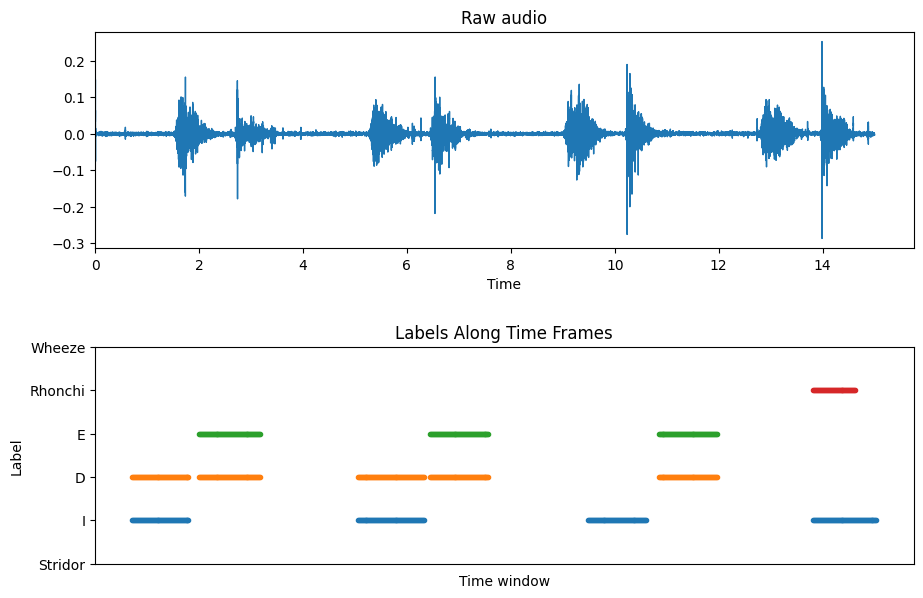

In [44]:
n = len(labels)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 7), sharex=False)
fig.tight_layout(pad=5)
waveform = wav.numpy()

num_channels, num_frames = waveform.shape
time_axis = torch.arange(0, num_frames) / sample_rate
ax1.plot(time_axis, waveform[0], linewidth=1)
ax1.set_xlim(xmin=0)
ax1.set_xlabel("Time")
ax1.set_title("Raw audio")

for i in range(labels.shape[1]):
    vals = [float('nan') if x==0 else x for x in labels[:,i]*(i+1)]
    ax2.scatter(np.arange(0, labels.shape[0]), vals, label=ALL_LABELS[i], marker='.')

# Add labels, legend and title to the bottom subplot
ax2.set_xlabel("Time window")
ax2.set_ylabel("Label")
ax2.set_title("Labels Along Time Frames")

# Set y-axis ticks to only show 0 and 1
ax2.set_xticks([])
ax2.set_yticks(ticks=range(labels.shape[1]), labels=[ALL_LABELS[-1]] + ALL_LABELS[:-1])

# Show the plot
# plt.show()
plt.savefig("sample_rate")


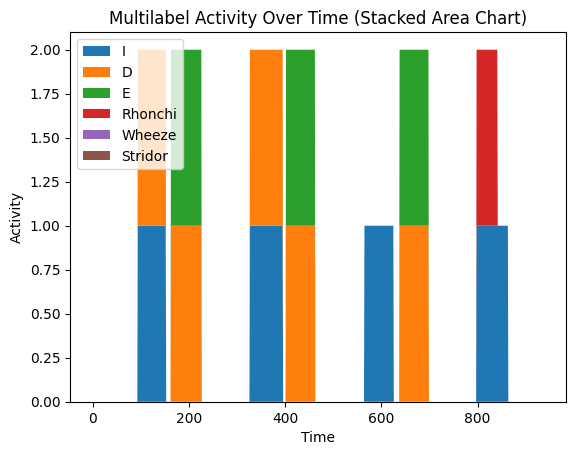

ValueError: The number of FixedLocator locations (16), usually from a call to set_ticks, does not match the number of ticklabels (15).

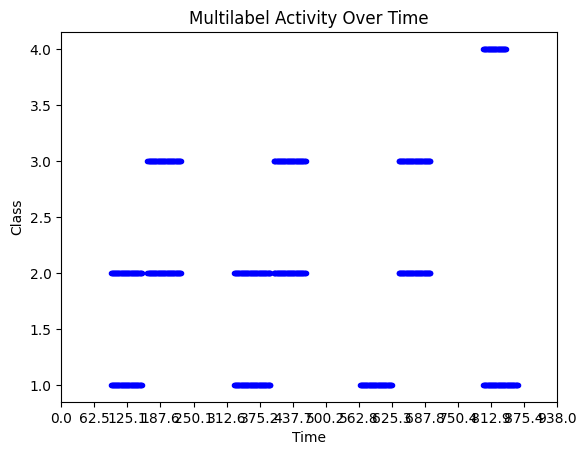

In [36]:
num_labels = labels.shape[1]
num_timesteps = labels.shape[0]
label1 = np.swapaxes(labels,0,1)
plt.stackplot(range(num_timesteps), label1, labels=ALL_LABELS)
plt.legend(loc='upper left')
plt.title('Multilabel Activity Over Time (Stacked Area Chart)')
plt.xlabel('Time')
plt.ylabel('Activity')
plt.show()

# labs=[aList[-1]] + aList[:-1]
# Create stacked line chart
for i in range(num_labels):
    vals = [float('nan') if x==0 else x for x in labels[:,i]*(i+1)]
    plt.scatter(range(num_timesteps), vals, marker='.', color='b')
    # labs[i+1] = ALL_LABELS[i]
# plt.fill_between(range(num_timesteps), np.zeros(num_timesteps), np.sum(labels, axis=1), alpha=0.2)
# plt.legend(loc='upper right')
plt.title('Multilabel Activity Over Time')
plt.xlabel('Time')
plt.ylabel('Class')
plt.xticks(ticks=np.arange(0,938,62.53), labels=range(15))
plt.yticks(ticks=range(num_labels), labels=[ALL_LABELS[-1]] + ALL_LABELS[:-1])
plt.show()

In [53]:
mel_spectrogram = torchaudio.transforms.MelSpectrogram(
    sample_rate=sample_rate,
    n_fft=256,
    win_length=window_length,
    hop_length=hop_length,
    center=True,
    pad_mode="reflect",
    power=1.0,
    n_mels=40,
)

mel_spec = mel_spectrogram(torch_signal_tensor)
mel_spec

RuntimeError: expected scalar type Double but found Float

In [66]:

def plot_spectrogram(specgram, title=None, ylabel="freq_bin"):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or "Spectrogram (db)")
    axs.set_ylabel(ylabel)
    axs.set_xlabel("frame")
    im = axs.imshow(librosa.power_to_db(specgram), origin="lower", aspect="auto")
    fig.colorbar(im, ax=axs)
    # plt.show(block=False)

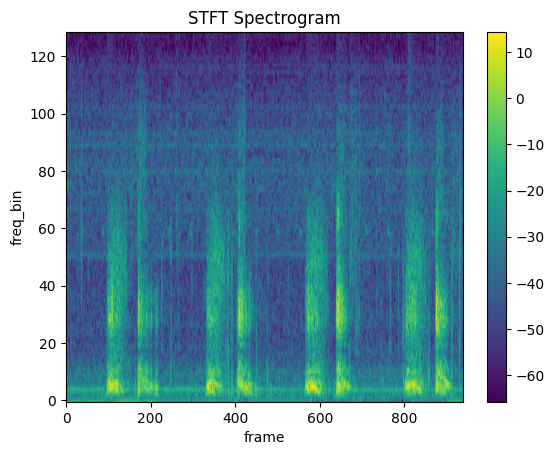

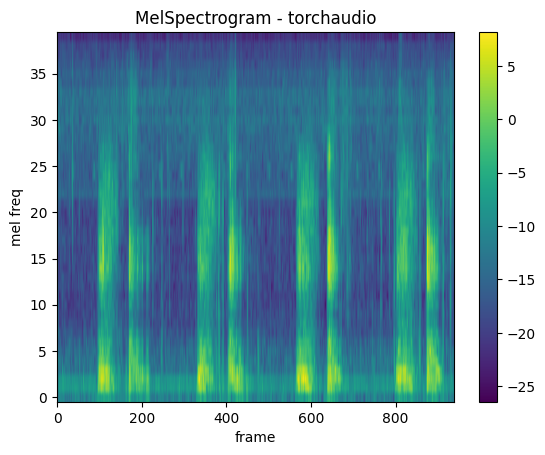

In [67]:
# Compute STFT spectrogram
# stft_transform = torchaudio.transforms.Spectrogram(n_fft=256, win_length=1024, hop_length=512)
stft = spectrogram(wav)

# Compute Mel spectrogram
# mel_transform = torchaudio.transforms.MelSpectrogram(sr=sample_rate, n_fft=2048, win_length=1024, hop_length=512, n_mels=128)
mel = mel_spectrogram(wav)

# Plot both spectrograms
plot_spectrogram(stft[0], title="STFT Spectrogram")
plt.savefig('stft')
plot_spectrogram(mel[0], title="MelSpectrogram - torchaudio", ylabel="mel freq")
plt.savefig('mel')

In [79]:
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
print(f"Using device {device}")
dataset = LungDataSet(file_list, transform=spectrogram,
                      targets_transform=label_encoder)
train_dataset = Subset(dataset=dataset, indices=range(0, np.floor(len(dataset)*0.8).astype(int)))
test_dataset = Subset(dataset=dataset, indices=range(np.floor(len(dataset)*0.8).astype(int), len(dataset)))

# seed = 0
batch_size = 64

train_loader = create_dataloader(train_dataset, batch_size)
test_loader = create_dataloader(test_dataset, batch_size)

# net = Net(num_recurrent_layers=1, num_input_features=201, hidden_layer_nodes=32, output_feature_nums=len(ALL_LABELS))

# num_epochs = 10
input_size = torch_signal.shape
hidden_layers = 32
# output_dimensions = len(label_dict)
model = Net(num_recurrent_layers=1, num_input_features=torch_signal.shape[1], hidden_layer_nodes=hidden_layers, output_feature_nums=len(ALL_LABELS))
learning_rate = 0.01
num_epochs = 10
# We are performing classification -> use crossentropy
loss_fn = nn.MSELoss()
optimizer= optim.Adam(model.parameters(), lr=learning_rate)
# Use a scheduler to reduce learning rate by 1/2 every 20 epochs
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)  # reduce the learning after

training_losses, testing_losses, training_accuracy, testing_accuracy = training_loop(num_epochs, model, optimizer, scheduler, loss_fn, train_loader, test_loader, device)

plt.figure(figsize=(4,6))
plt.plot(training_losses, label="train_loss")
plt.plot(testing_losses, label="test_loss")
plt.legend()
plt.title("loss")
plt.savefig("Figures/SPEECHCOMMANDS_loss.png")
plt.clf()

plt.figure(figsize=(4,6))
plt.plot(training_accuracy, label="train_accuracy")
plt.plot(testing_accuracy, label="test_accuacy")
plt.legend()
plt.title("accuracy")
plt.savefig("Figures/SPEECHCOMMANDS_accuracy.png")
plt.clf()

Using device cpu


AttributeError: 'tuple' object has no attribute 'dim'

In [72]:
torch_signal.shape

torch.Size([1, 129, 938])